1. Cargar y Preprocesar Datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

C:\Users\yporq\AppData\Local\Temp\ipykernel_41932\3580569497.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Class"], palette=["blue", "red"])


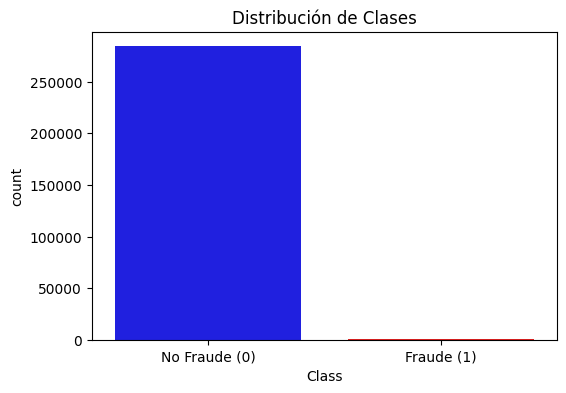

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Cargar el dataset
df = pd.read_csv("./data/creditcard.csv")

# Revisar estructura
print(df.info())

# Revisar balance de clases
print(df["Class"].value_counts())

# Visualizar balance de fraudes vs no fraudes
plt.figure(figsize=(6,4))
sns.countplot(x=df["Class"], palette=["blue", "red"])
plt.xticks([0, 1], ["No Fraude (0)", "Fraude (1)"])
plt.title("Distribución de Clases")
plt.show();


2. Entrenar el Modelo Isolation Forest

In [11]:
# Seleccionar características y variable objetivo
X = df.drop(columns=["Class"])
y = df["Class"]

# Normalizar "Amount" y "Time" (mejora la detección de anomalías)
scaler = StandardScaler()
X[["Amount", "Time"]] = scaler.fit_transform(X[["Amount", "Time"]])

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
from sklearn.ensemble import IsolationForest

# Entrenar Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso_forest.fit(X_train)

# Predecir anomalías en el conjunto de prueba
y_pred = iso_forest.predict(X_test)

# Convertir predicciones a formato binario (fraude = 1, no fraude = 0)
y_pred_bin = np.where(y_pred == -1, 1, 0)


contamination=0.01 asume que el 1% de las transacciones son fraudes.

n_estimators=100 usa 100 árboles para detectar anomalías.

predict() devuelve -1 para fraudes y 1 para no fraudes, lo convertimos a 0 y 1.

3. Evaluar el Modelo

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred_bin))
print("Precision:", precision_score(y_test, y_pred_bin))
print("Recall:", recall_score(y_test, y_pred_bin))
print("F1-score:", f1_score(y_test, y_pred_bin))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bin))

Accuracy: 0.9897826621256276
Precision: 0.10197368421052631
Recall: 0.6326530612244898
F1-score: 0.17563739376770537
Confusion Matrix:
 [[56318   546]
 [   36    62]]


Métricas importantes:

    Precision: ¿Cuántos de los fraudes detectados realmente eran fraudes?
    Recall: ¿Cuántos fraudes fueron detectados correctamente?
    Confusion Matrix: Muestra los falsos positivos y negativos.

4. Visualizar la Distribución de Anomalías

C:\Users\yporq\AppData\Local\Temp\ipykernel_41932\3347659591.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_test["Fraude_Predicho"], y=df_test["Amount"], palette=["blue", "red"])


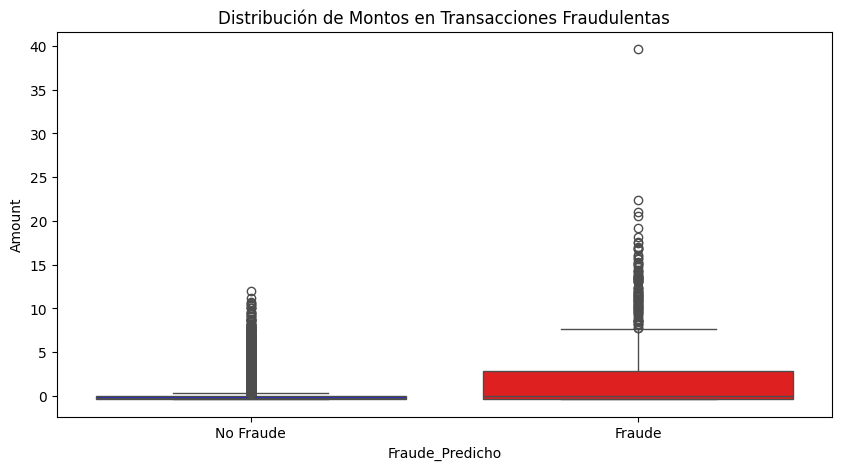

In [14]:
df_test = X_test.copy()
df_test["Fraude_Predicho"] = y_pred_bin

plt.figure(figsize=(10,5))
sns.boxplot(x=df_test["Fraude_Predicho"], y=df_test["Amount"], palette=["blue", "red"])
plt.xticks([0, 1], ["No Fraude", "Fraude"])
plt.title("Distribución de Montos en Transacciones Fraudulentas")
plt.show()


5. Ajustar Isolation Forest con GridSearchCV
   
Para encontrar los mejores parámetros del modelo, podemos usar GridSearchCV:

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Definir la métrica personalizada basada en la puntuación de las anomalías
def isolation_forest_score(estimator, X):
    """ Retorna el porcentaje de anomalías detectadas """
    return np.mean(estimator.predict(X) == -1)  # % de valores detectados como anomalía (-1)

# Crear scorer personalizado
custom_scorer = make_scorer(isolation_forest_score, greater_is_better=True)

# Definir hiperparámetros a optimizar
param_grid = {
    "n_estimators": [50, 100, 200],
    "contamination": [0.005, 0.01, 0.02]
}

# Aplicar GridSearchCV con Isolation Forest
grid_search = GridSearchCV(IsolationForest(random_state=42), param_grid, cv=3, scoring=custom_scorer)
grid_search.fit(X_train)

print("Mejores parámetros:", grid_search.best_params_);


c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScore

Mejores parámetros: {'contamination': 0.005, 'n_estimators': 50}


IsolationForest es no supervisado, así que scoring="recall" no funciona.

Creamos isolation_forest_score(), que mide el porcentaje de transacciones detectadas como anomalía.

Usamos make_scorer() para integrarlo en GridSearchCV.

Evaluamos distintos valores de n_estimators y contamination para encontrar los mejores.

 Esto probará diferentes valores de contamination y n_estimators para mejorar la detección.